# Zadanie nr 3 - Kompresja tekstu

In [1]:
from treelib import Tree
from heapq import heappush, heappop
from collections import Counter
from bitarray import bitarray, decodetree
from bitarray.util import *
from random import shuffle
import numpy as np
import matplotlib.pyplot as plt
from time import time
import os

Zadanie polega na implementacji dwóch algorytmów kompresji:

* statycznego algorytmu Huffmana
* dynamicznego algorytmu Huffmana

## 1. Statyczny algorytm Huffmana

In [2]:
class Node:
    def __init__(self, *args, **kwargs):
        self.weight = args[-1]
        self.elements = args[:-1]

    def __str__(self):
        string = ""
        for element in self.elements:
            string += str(element)
        return string

    def __repr__(self):
        return str(self)

    def __lt__(self, other):
        return self.weight < other.weight

wersja niekorzystająca z pomocniczych struktur:

In [3]:
def huffman(letter_counts):
    nodes = []
    for a, weight in letter_counts.items():
        nodes.append(Node(a, weight))

    internal_nodes = []
    leafs = sorted(nodes, key=lambda n: n.weight)

    while(len(leafs) + len(internal_nodes) > 1):
        element_1 = get_lowest_weight_node(leafs, internal_nodes)
        element_2 = get_lowest_weight_node(leafs, internal_nodes)

        internal_nodes.append(
            Node(element_1, element_2, element_1.weight + element_2.weight))

    return internal_nodes[0]


def get_lowest_weight_node(leafs, internal):
    if not internal or (leafs and leafs[0].weight < internal[0].weight):
        return leafs.pop(0)
    return internal.pop(0)

implementacja wykorzystująca kopiec (kod bardziej zwięzły kosztem nieznacznego spowolnienia):

In [4]:
def huffman_heap(letter_counts):
    heap = []
    for a, weight in letter_counts.items():
        heappush(heap, Node(a, weight))

    while(len(heap) > 1):
        element_1 = heappop(heap)
        element_2 = heappop(heap)

        heappush(heap, Node(element_1, element_2,
                 element_1.weight + element_2.weight))

    return heappop(heap)

In [5]:
def get_codes(head):
    codes = {}
    head.code = ''

    def walk_tree(node):
        for i, child in enumerate(node.elements):
            child.code = node.code + str(i)

            if len(child.elements) > 1:
                walk_tree(child)
            else:
                codes[child.elements[0]] = bitarray(child.code)

    walk_tree(head)
    return codes

#### wizualizacja drzewa

Do wizualizacji drzewa wykorzystałem pomocniczą bibliotekę treelib:

In [6]:
def show_tree(head):
    tree = Tree()
    tree.create_node(str(head) + ' weight: ' +
                     str(head.weight), head, parent=None)
    head.code = ''

    def create_tree(node):
        for i, child in enumerate(node.elements):
            child.code = node.code + str(i)
            tree.create_node(str(child) + ' weight: ' + str(child.weight) + ' code: ' + str(child.code),
                             child, parent=node)
            if len(child.elements) > 1:
                create_tree(child)

    create_tree(head)
    tree.show()

In [7]:
text = 'abracadabra'
head = huffman(Counter(text))
show_tree(head)

arcdb weight: 11
├── a weight: 5 code: 0
└── rcdb weight: 6 code: 1
    ├── cdb weight: 4 code: 11
    │   ├── b weight: 2 code: 111
    │   └── cd weight: 2 code: 110
    │       ├── c weight: 1 code: 1100
    │       └── d weight: 1 code: 1101
    └── r weight: 2 code: 10



#### kompresja i dekompresja

Skompresowany plik ma następującą postać:
* Pierwsze 4 bajty określają liczbę znaków w alfabecie.
* Następnie, dla każdego znaku z alfabetu zapisujemy ten znak w kodzie utf-32, potem (na jednym bajcie) długość kodu Huffmana dla znaku i na koniec tenże kod.
* Po tym zapisujemy liczbę bitów znaczących zakodowanego tekstu (na 4 bajtach), a następnie zakodowany tekst.

W nagłówku skorzystałem z kodowania znaków utf-32, gdyż kodowanie to cechuje stała liczba bitów, co jest wygodne w odkodowywaniu. Można by zaoszczędzić trochę miejsca zapisując dodatkowo długość znaku w bajtach, korzystając np. z utf-8.

In [30]:
def encode(text, file):
    node = huffman(Counter(text))
    codes = get_codes(node)
    encoded_text = bitarray()
    encoded_text.encode(codes, text)

    mapping = bitarray()

    for letter, code in codes.items():
        letter_utf = bitarray()
        letter_utf.frombytes(letter.encode('utf-32'))

        code_len = bitarray()
        code_len.frombytes(len(code).to_bytes(1, 'big'))
        mapping += letter_utf + code_len + code

    letters_count = bitarray()
    letters_count.frombytes(len(codes).to_bytes(4, 'big'))
    text_bit_size = bitarray()
    text_bit_size.frombytes(len(encoded_text).to_bytes(4, 'big'))

    bit_seq = bitarray()
    bit_seq = letters_count + mapping + text_bit_size + encoded_text

    with open(file, 'wb') as f:
        bit_seq.tofile(f)


def decode(file):
    with open(file, 'rb') as f:
        bit_seq = bitarray()
        bit_seq.fromfile(f)

    letters_count = ba2int(bit_seq[:32])
    decode_dict = {}
    i = 32

    for _ in range(letters_count):
        letter = bit_seq[i:i+64].tobytes().decode('utf-32')
        i += 64
        code_len = ba2int(bit_seq[i:i+8])
        i += 8
        code = bit_seq[i:i+code_len]
        i += code_len

        decode_dict[letter] = code

    text_len = ba2int(bit_seq[i:i+32])
    i += 32

    decode_tree = decodetree(decode_dict)
    text = ''.join(bit_seq[i:i+text_len].decode(decode_tree))
    return text

proste testy poprawności:

In [34]:
text = 'abracadabra'
encode(text, 'encoded')
print(decode('encoded'))

text = 'ż,ó,ł,ć'
encode(text, 'encoded')
print(decode('encoded'))

abracadabra
ż,ó,ł,ć


## 2. Dynamiczny algorytm Huffmana

In [53]:
class AdaptiveNode:
    def __init__(self, char, weight=0):
        self.char = char
        self.weight = weight
        self.parent = None
        self.children = [None, None]

    def get_code(self):
        if not self.parent:
            return bitarray()
        if self == self.parent.children[0]:
            return self.parent.get_code() + bitarray('0')
        else:
            return self.parent.get_code() + bitarray('1')

    def add_child(self, index, child):
        self.children[index] = child
        child.parent = self

    def get_char_repr(self):
        if not self.children[0]:
            return self.char

        return self.children[0].get_char_repr() + self.children[1].get_char_repr()

    def get_sibling(self):
        node = self
        levels_change = 0

        while node.parent:
            if node == node.parent.children[0]:
                sibling = node.parent.children[1].next_in_line(
                    0, levels_change)
                if sibling:
                    return sibling

            node = node.parent
            levels_change += 1

        return node.next_in_line(0, levels_change - 1)

    def next_in_line(self, current_level, end_level):
        if current_level == end_level:
            return self
        if not self.children[0]:
            return None
        return self.children[0].next_in_line(current_level + 1, end_level) or \
            self.children[1].next_in_line(current_level + 1, end_level)

    def increment(self):
        self.weight += 1

        if self.parent:
            sibling = self.get_sibling()
            if sibling:
                if self.weight > sibling.weight:
                    next_sibling = sibling.get_sibling()

                    while next_sibling and sibling.weight == next_sibling.weight:
                        sibling = next_sibling
                        next_sibling = sibling.get_sibling()

                    if sibling != self.parent:
                        swap_nodes(self, sibling)

            self.parent.increment()

    def __str__(self):
        return f'char(s): {"".join(sorted(self.get_char_repr()))}, \
weight: {self.weight}, \
code:{"".join(list(map(str, self.get_code())))}'

    def __repr__(self):
        return str(self)

    def __lt__(self, other):
        return self.weight < other.weight


def swap_nodes(node_1, node_2):
    node_1.parent, node_2.parent = node_2.parent, node_1.parent

    if node_2 == node_1.parent.children[0]:
        node_1.parent.children[0] = node_1
    else:
        node_1.parent.children[1] = node_1

    if node_1 == node_2.parent.children[0]:
        node_2.parent.children[0] = node_2
    else:
        node_2.parent.children[1] = node_2

In [54]:
def adaptive_huffman(text):
    nodes = {"#": AdaptiveNode("#", weight=0)}
    head = nodes["#"]
    bit_seq = bitarray()

    for letter in text:
        if letter in nodes:
            node = nodes[letter]
            bit_seq += node.get_code()
            node.increment()
        else:
            updated_node = nodes["#"]
            bit_seq += updated_node.get_code()

            letter_bits = bitarray()
            letter_bits.frombytes(letter.encode('utf-32'))
            bit_seq += letter_bits

            node = AdaptiveNode(letter, weight=1)
            nodes[letter] = node
            del nodes["#"]
            zero_node = AdaptiveNode("#", weight=0)
            updated_node.add_child(0, zero_node)
            updated_node.add_child(1, node)
            nodes["#"] = zero_node

            updated_node.increment()

    return head, bit_seq

#### wizualizacja drzewa

In [55]:
def show_tree_adaptive(head):
    tree = Tree()
    tree.create_node(str(head), head, parent=None)

    def create_tree(node):
        for i, child in enumerate(node.children):
            tree.create_node(str(child),
                             child, parent=node)

            if child and child.children[0] and child.children[1]:
                create_tree(child)

    create_tree(head)
    tree.show()

In [56]:
text = 'abracadabra'
head, bits = adaptive_huffman(text)
show_tree_adaptive(head)

char(s): #abcdr, weight: 11, code:
├── char(s): #bcdr, weight: 6, code:1
│   ├── char(s): #cd, weight: 2, code:10
│   │   ├── char(s): #d, weight: 1, code:100
│   │   │   ├── char(s): #, weight: 0, code:1000
│   │   │   └── char(s): d, weight: 1, code:1001
│   │   └── char(s): c, weight: 1, code:101
│   └── char(s): br, weight: 4, code:11
│       ├── char(s): b, weight: 2, code:111
│       └── char(s): r, weight: 2, code:110
└── char(s): a, weight: 5, code:0



#### kompresja i dekompresja

W tym przypadku również na początku zapisałem na 4 bajtach liczbę bitów znaczących, aby nie interpretować zer, które na końcu pojawiają się z uwagi na zapis pełnych bajtów w pliku.

In [46]:
def encode_adaptive(text, file):
    head, bits = adaptive_huffman(text)
    
    bit_size = bitarray()
    bit_size.frombytes(len(bits).to_bytes(4, 'big'))
    
    bits = bit_size + bits
    
    with open(file, 'wb') as f:
        bits.tofile(f)

In [47]:
def decode_adaptive(file):
    with open(file, 'rb') as f:
        bit_seq = bitarray()
        bit_seq.fromfile(f)
        
    text = ""
    letters_count = ba2int(bit_seq[:32])
    nodes = {"#": AdaptiveNode("#", weight=0)}
    head = nodes["#"]
    current_node = head
    i = 32

    while i <= letters_count+32:
        if not current_node.children[0]:
            if current_node.char != "#":
                text += current_node.char
                current_node.increment()

            else:
                letter = bit_seq[i:i+64].tobytes().decode('utf-32')
                i += 64
                text += letter
                
                node = AdaptiveNode(letter, weight=1)
                nodes[letter] = node
                del nodes["#"]
                zero_node = AdaptiveNode("#")
                current_node.add_child(0, zero_node)
                current_node.add_child(1, node)
                nodes["#"] = zero_node
                current_node.increment()

            current_node = head

        if i < letters_count+32:
            current_node = current_node.children[1] if bit_seq[i] == 1 else current_node.children[0]

        i += 1

    return text

proste testy poprawności:

In [48]:
text = 'abracadabra'
encode_adaptive(text, 'encoded')
print(decode_adaptive('encoded'))

text = 'żółć'
encode_adaptive(text, 'encoded')
print(decode_adaptive('encoded'))

abracadabra
żółć


## 3. Testy

Zmierzyć współczynnik kompresji (wyrażone w procentach: 1 - plik_skompresowany / plik_nieskompresowany) dla plików tekstowych o rozmiarach: 1kB, 10kB, 100kB, 1MB, dla różnych typów plików: plik tekstowy z portalu Guttenberga, plik źródłowy z Githubu, plik ze znakami losowanymi z rozkładu jednostajnego.

#### łańcuchy znaków do testów

W celu pozyskania łańcuchów znaków do testów, pobrałem duże pliki z portalu Guttenberga i Githuba, a następnie wyciąłem z nich fragmenty o zadanej wielkości za pomocą komendy dd w terminalu linuxa. Plik ze znakami z rozkładu jednostajnego wygenerowałem z użyciem biblioteki numpy, a następnie pociąłem poleceniem dd.

In [58]:
# normal distribution random
alphabet = list(range(48, 126))
shuffle(alphabet)

with open('text_files/random_normal_full.txt', 'w') as f:
    for _ in range(5000000):
        random_index = round(np.random.normal(len(alphabet)//2, 2))
        if random_index < 0 or random_index >= len(alphabet):
            continue
        f.write(chr(alphabet[random_index]))
        
!dd if=text_files/random_normal_full.txt of=text_files/random_normal_1MB.txt skip=0 count=11048576  iflag=skip_bytes,count_bytes
!dd if=text_files/random_normal_full.txt of=text_files/random_normal_100kB.txt skip=2048 count=102400  iflag=skip_bytes,count_bytes
!dd if=text_files/random_normal_full.txt of=text_files/random_normal_10kB.txt skip=4096 count=10240  iflag=skip_bytes,count_bytes
!dd if=text_files/random_normal_full.txt of=text_files/random_normal_1kB.txt skip=800 count=1024  iflag=skip_bytes,count_bytes

9765+1 records in
9765+1 records out
5000000 bytes (5,0 MB, 4,8 MiB) copied, 0,0265645 s, 188 MB/s
200+0 records in
200+0 records out
102400 bytes (102 kB, 100 KiB) copied, 0,00129869 s, 78,8 MB/s
20+0 records in
20+0 records out
10240 bytes (10 kB, 10 KiB) copied, 0,000306672 s, 33,4 MB/s
2+0 records in
2+0 records out
1024 bytes (1,0 kB, 1,0 KiB) copied, 0,000642887 s, 1,6 MB/s


In [59]:
sizes = ['1kB', '10kB', '100kB', '1MB']

# powieść z portalu Guttenberg
book_files = [f'text_files/anna_karenina_{size}.txt' for size in sizes]

books = []
for book_file in book_files:
    with open(book_file, 'r') as f:
        books.append(''.join(f).replace('#', '^'))
    
# kod źródłowy
source_code_files = [f'text_files/source_code_{size}.c' for size in sizes]
source_codes = []
for source_file in source_code_files:
    with open(source_file, 'r') as f:
        source_codes.append(''.join(f).replace('#', '^'))
        

# normal distribution random
random_normal_files = [f'text_files/random_normal_{size}.txt' for size in sizes]
random_normals = []
for random_normal in random_normal_files:
    with open(random_normal, 'r') as f:
        random_normals.append(''.join(f).replace('#', '^'))

#### współczynnik kompresji

In [60]:
def get_compression_rate(file, text, static=True):
    file_size = os.path.getsize(file)
    if static:
        encode(text, 'encoded')
    else:
        encode_adaptive(text, 'encoded')
        
    encoded_size = os.path.getsize('encoded')
    return 1 - encoded_size/file_size

In [21]:
def plot_compression_rate(rates_static, rates_adaptive, title, sizes):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    ax[0].set_title(title + ' STATIC')
    ax[0].bar(sizes, rates_static, color='tan')
    
    ax[1].set_title(title + ' ADAPTIVE')
    ax[1].bar(sizes, rates_adaptive, color='sienna')
    
    plt.show()

--text_files/anna_karenina--
STATIC HUFFMAN COMPRESSION
1kB: 2.636719%
10kB: 39.658203%
100kB: 44.825195%
1MB: 45.825195%

ADAPTIVE HUFFMAN COMPRESSION
1kB: 10.253906%
10kB: 40.751953%
100kB: 44.989258%
1MB: 45.842171%


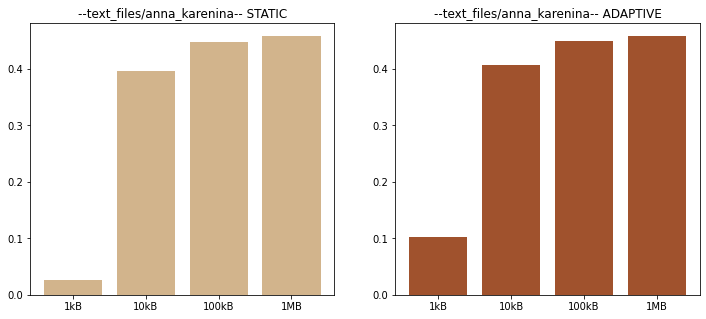


--text_files/source_code--
STATIC HUFFMAN COMPRESSION
1kB: -23.046875%
10kB: 29.824219%
100kB: 35.355469%
1MB: 34.797955%

ADAPTIVE HUFFMAN COMPRESSION
1kB: -12.304688%
10kB: 31.328125%
100kB: 35.500000%
1MB: 34.809113%


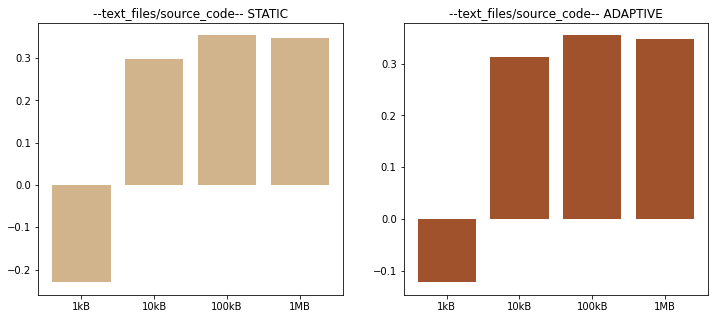


--text_files/random_normal--
STATIC HUFFMAN COMPRESSION
1kB: 45.898438%
10kB: 59.550781%
100kB: 60.875000%
1MB: 61.034340%

ADAPTIVE HUFFMAN COMPRESSION
1kB: 48.437500%
10kB: 59.824219%
100kB: 60.897461%
1MB: 61.034260%


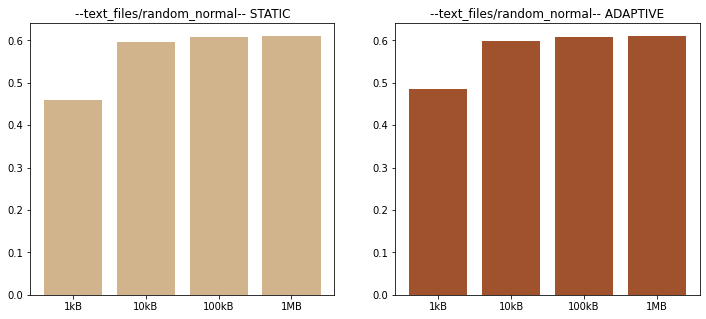

In [65]:
for files, texts in zip([book_files, source_code_files, random_normal_files], [books, source_codes, random_normals]):
    file_type = f'--{"_".join(files[0].split("_")[:3])}--'
    print(file_type)
    
    print('static huffman compression'.upper())
    rates_static = []
    for i, size in enumerate(sizes):
        rates_static.append(get_compression_rate(files[i], texts[i]))
        print(f'{size}: {rates_static[-1]:%}')
    
    print('\nadaptive huffman compression'.upper())
    rates_adaptive = []
    for i, size in enumerate(sizes):
        rates_adaptive.append(get_compression_rate(files[i], texts[i], static=False))
        print(f'{size}: {rates_adaptive[-1]:%}')
    
    
    plot_compression_rate(rates_static, rates_adaptive, file_type, sizes)
    print()

Współczynnik rośnie wraz ze wzrostem rozmiaru pliku. Dla bardzo krótkich plików, kodowanie słownika w nagłówku było na tyle ekstensywne, że współczynnik okazał się ujemny. Zależność zachowuje się podobnie dla każdego typu tekstu.

4. Zmierzyć czas kompresji i dekompresji dla plików z punktu 3 dla każdego algorytmu.

In [23]:
def count_time(text, static=True):
    if static:
        encode_start = time()
        encode(text, 'encoded')
        encode_end = time()

        decode_start = time()
        decode('encoded')
        decode_end = time()
    else:
        encode_start = time()
        encode_adaptive(text, 'encoded')
        encode_end = time()

        decode_start = time()
        decode_adaptive('encoded')
        decode_end = time()
    
    return encode_end - encode_start, decode_end - decode_start

In [66]:
def plot_time(static_times, adaptive_times, title, sizes):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    ax[0].set_title(title + ' STATIC')
    ax[0].bar(sizes, static_times[0], color='mediumturquoise')
    ax[0].bar(sizes, static_times[1], bottom=static_times[0], color='aquamarine')
    ax[0].legend(labels=["encoding", "decoding"])
    ax[0].set_ylim(0, 1)
    
    ax[1].set_title(title + ' ADAPTIVE')
    ax[1].bar(sizes, adaptive_times[0], color='plum')
    ax[1].bar(sizes, adaptive_times[1], bottom=adaptive_times[0], color='slateblue')
    ax[1].legend(labels=["encoding", "decoding"])
    ax[1].set_ylim(0, 1)
    
    plt.show()

--text_files/anna_karenina--
STATIC HUFFMAN COMPRESSION
1kB: encoding: 0.00193 decoding: 0.00038
10kB: encoding: 0.00168 decoding: 0.00167
100kB: encoding: 0.01178 decoding: 0.00394
1MB: encoding: 0.08102 decoding: 0.03639

ADAPTIVE HUFFMAN COMPRESSION
1kB: encoding: 0.00771 decoding: 0.00612
10kB: encoding: 0.05947 decoding: 0.04819
100kB: encoding: 0.54559 decoding: 0.44019
1MB: encoding: 5.35582 decoding: 4.30919


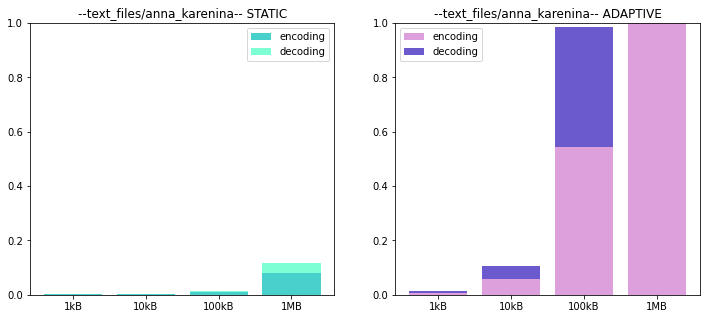


--text_files/source_code--
STATIC HUFFMAN COMPRESSION
1kB: encoding: 0.00187 decoding: 0.00049
10kB: encoding: 0.00279 decoding: 0.00125
100kB: encoding: 0.01185 decoding: 0.00412
1MB: encoding: 0.08917 decoding: 0.03929

ADAPTIVE HUFFMAN COMPRESSION
1kB: encoding: 0.01036 decoding: 0.00897
10kB: encoding: 0.08220 decoding: 0.05898
100kB: encoding: 0.64594 decoding: 0.52058
1MB: encoding: 6.42764 decoding: 5.20771


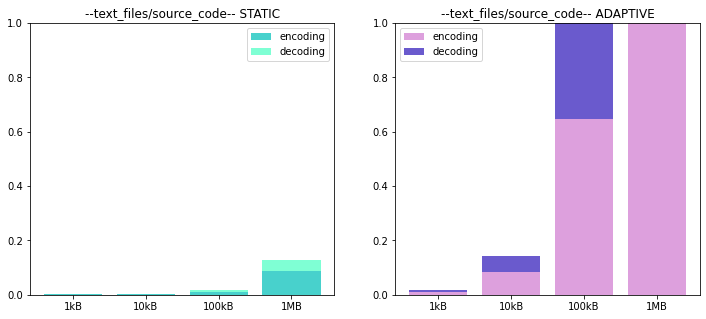


--text_files/random_normal--
STATIC HUFFMAN COMPRESSION
1kB: encoding: 0.00041 decoding: 0.00015
10kB: encoding: 0.00215 decoding: 0.00035
100kB: encoding: 0.00661 decoding: 0.00216
1MB: encoding: 0.30325 decoding: 0.10687

ADAPTIVE HUFFMAN COMPRESSION
1kB: encoding: 0.00492 decoding: 0.00348
10kB: encoding: 0.03927 decoding: 0.03120
100kB: encoding: 0.38417 decoding: 0.30323
1MB: encoding: 18.40388 decoding: 14.66428


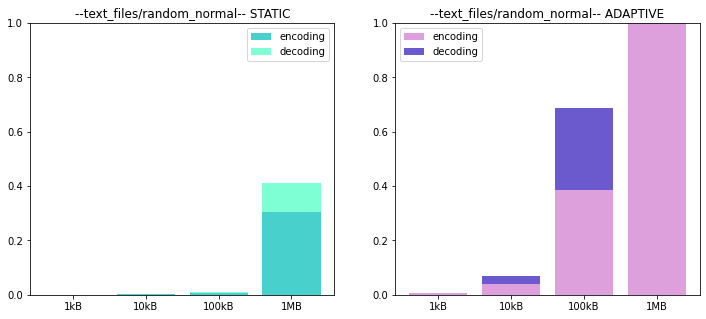

In [67]:
for files, texts in zip([book_files, source_code_files, random_normal_files], [books, source_codes, random_normals]):
    file_type = f'--{"_".join(files[0].split("_")[:3])}--'
    print(file_type)
    
    static_times = [[], []]
    adaptive_times = [[], []]
    
    print('static huffman compression'.upper())
    for i, size in enumerate(sizes):
        encode_time, decode_time = count_time(texts[i])
        static_times[0].append(encode_time)
        static_times[1].append(decode_time)
        
        print(f'{size}: encoding: {encode_time:.5f} decoding: {decode_time:.5f}')
    
    print('\nadaptive huffman compression'.upper())
    for i, size in enumerate(sizes):
        encode_time, decode_time = count_time(texts[i], static=False)
        adaptive_times[0].append(encode_time)
        adaptive_times[1].append(decode_time)
        
        print(f'{size}: encoding: {encode_time:.5f} decoding: {decode_time:.5f}')
    
    plot_time(static_times, adaptive_times, file_type, sizes)
    print()

## 4. Wnioski

- Kodowanie Huffmana ma sens szczególnie dla tekstów długich, gdyż współczynnik kompresji jest dla nich na ogół największy; oraz dla tekstów, w których występowanie poszczególnych znaków jest bardzo nierównomierne.

- Kodowane adaptacyjne daje większy współczynnik korelacji dla krótszych tekstów niż algorytm statyczny. Wynika to głównie z zaproponowanego sposobu zapisywania klucza potrzebnego do odkodowania pliku dla wersji statycznej. Dla dłuższych tekstów obie wersje osiągały podobne wartości współczynnika.

- Kodowanie dynamiczne okazało się dużo wolniejsze od statycznego, szczególnie jeśli chodzi o czas dekompresji.

M. Hawryluk 23.04.2021